In [1]:
import torch as tch
from matplotlib import pyplot as plt

In [3]:
from genpg.model import Encoder, Decoder
from genpg.dataset import read_train_data, read_test_data

In [3]:
image_dims = (28, 28)
latent_dim = 10

In [4]:
dev = tch.device("cuda")

In [6]:
(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

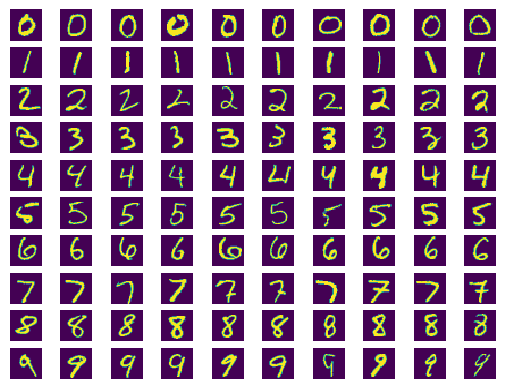

In [14]:
fig, axs = plt.subplots(10, 10)
for col in range(10):
    for row, i in enumerate([i for i, l in enumerate(test_labels) if l == col]):
        if row >= 10:
            break
        ax = axs[col, row]
        ax.axis('off')
        ax.imshow(test_images[i], interpolation='nearest')
fig.show()

In [5]:
enc = Encoder(image_dims, latent_dim).to(dev)
dec = Decoder(latent_dim, image_dims).to(dev)

In [8]:


batch_size = 2
x = tch.rand((batch_size, *image_dims), device=dev)
z_mean, z_var = enc.forward(x)
z = z_mean + z_var * tch.randn((batch_size, latent_dim), device=dev)
y = dec.forward(z)
y

tensor([[[0.0586, 0.0497, 0.0000,  ..., 0.0036, 0.0000, 0.0291],
         [0.0863, 0.3439, 0.0000,  ..., 0.0624, 0.0000, 0.0000],
         [0.1218, 0.0000, 0.0234,  ..., 0.0066, 0.2231, 0.0615],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1584, 0.0923],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1107, 0.0000],
         [0.0000, 0.2073, 0.1094,  ..., 0.1042, 0.0000, 0.0559]],

        [[0.0240, 0.0581, 0.0000,  ..., 0.0286, 0.0000, 0.0576],
         [0.0917, 0.3334, 0.0000,  ..., 0.0305, 0.0000, 0.0000],
         [0.1188, 0.0000, 0.0029,  ..., 0.0000, 0.2356, 0.0487],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1485, 0.0851],
         [0.0000, 0.0000, 0.0075,  ..., 0.0000, 0.1164, 0.0000],
         [0.0000, 0.1915, 0.1059,  ..., 0.1279, 0.0000, 0.0661]]],
       device='cuda:0', grad_fn=<ViewBackward0>)